# Prototypage de classifeur

Prototypage de de classifeur en utilisant des boolean index en cascade (for the speed and the lolz!)

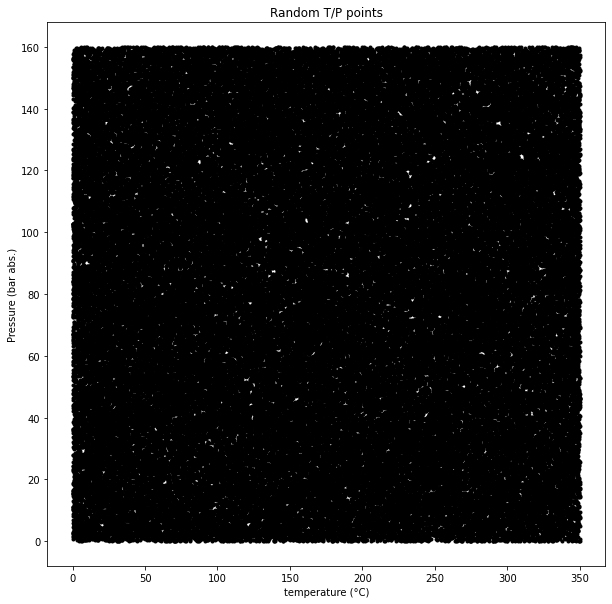

In [69]:
import numpy as np


def random_array(size, dim=2):
    """
    Generate a random array of temperature (0-350°c) and pressure (0-160 bar)
    """
    return np.random.rand(int(size), dim) * np.array([350,160])

# Generate a random array of size 1e5
array = random_array(1e5)

# Plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.show()

## Découpe en cadran
Découpe des données en quadrant afin de gagner du temps sur les filtrages plus complexe.

https://fr.wikipedia.org/wiki/Quadrant_(math%C3%A9matiques)

Boolean index Quandrant:	2.82 ms ± 95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


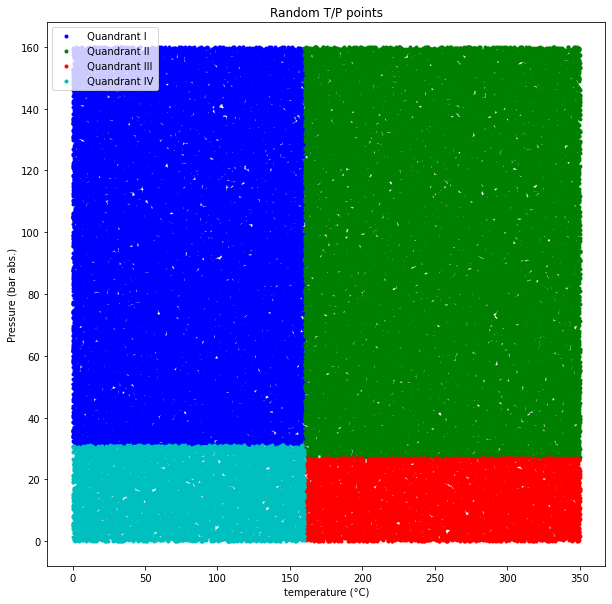

In [70]:
def quadrant_index(array):
    """
    Takes a numpy array cut it into four qudrant following two axis, [160, :] and [: , ]
    """
    # the simple version 2.97 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    # index_1 = (array[:, 0] < 160) & (array[:, 1] > 31)   # out of domaine quadrant I
    # index_2 = (array[:, 0] >= 160) & (array[:, 1] >= 27) # AN/GV quadrant II
    # index_3 = (array[:, 0] >= 160) & (array[:, 1] < 27)  # out of domaine quadrant III
    # index_4 = (array[:, 0] < 160) & (array[:, 1] <= 31)  # API/APR quandrant III
    
    # marginaly faster version 2.7 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    index_a = (array[:, 0] < 160)
    index_b = np.logical_not(index_a)
    index_c = (array[:, 1] > 31) 
    index_d = np.logical_not(index_c)
    index_e = (array[:, 1] < 27)
    index_f = np.logical_not(index_e)
    
    index_1 = index_a & index_c
    index_2 = index_b & index_f
    index_3 = index_b & index_e
    index_4 = index_a & index_d
    
    return  (array[index_1], array[index_2], array[index_3], array[index_4]) 

#Performance indicator - remove if not needed - run the function 7000 times.
print('Boolean index Quandrant:\t', end='')
%timeit quadrant_index(array)

quadrant = quadrant_index(array)
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(quadrant[0][:, 0], quadrant[0][:, 1], 'b.', label=' Quandrant I')
plt.plot(quadrant[1][:, 0], quadrant[1][:, 1], 'g.', label=' Quandrant II')
plt.plot(quadrant[2][:, 0], quadrant[2][:, 1], 'r.', label=' Quandrant III')
plt.plot(quadrant[3][:, 0], quadrant[3][:, 1], 'c.', label=' Quandrant IV')
plt.legend()
plt.show()

## API/APR 
Le plus simple, car c'est un simple rectange.

Boolean index API:	60.7 µs ± 459 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


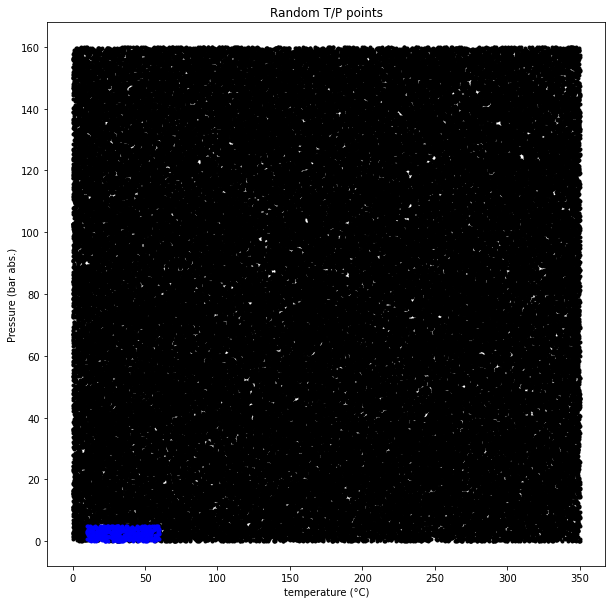

In [92]:
def api_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,60] for
    the first dimension and between [0,5] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 0) & (array[:, 0] <= 60) & (array[:, 1] < 5)
    

    return array[index]

#Performance indicator - remove if not needed - run the function 7000 times.
print('Boolean index API:\t', end='')
%timeit api_index(quadrant[3]) 

api_data = api_index(quadrant[3]) 
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
plt.show()

## AN/RRA Filter

Un peu plus compliqué, la différence entre deux rectangles.

Boolean index AN/RRA:	132 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


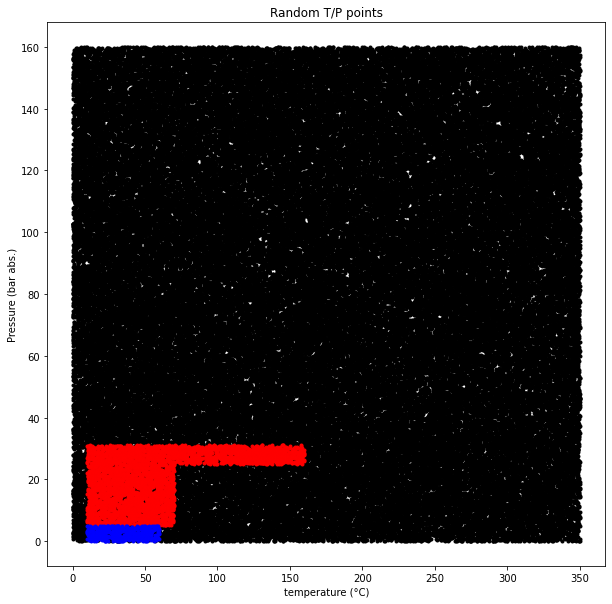

In [72]:
def anrra_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 5) & (array[:, 0] <= 160) & (array[:, 1] <= 31) & np.logical_not((array[:, 0] >= 70) & (array[:, 1] < 25))
    

    return array[index]

#Performance indicator - remove if not needed - run the function 7000 times.
print('Boolean index AN/RRA:\t', end='')
%timeit anrra_index(quadrant[3]) # Quadrant IV

anrra_data = anrra_index(quadrant[3]) # Quadrant IV
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
plt.show()

## AN/GV 
Les choses difficiles commences. On importe les fonctions Psat selon IAPWS97 et celsius_to_kelvin 

In [73]:
from iapws import IAPWS97

def celsius_to_kelvin(temperature):
    '''
    Convert Celsius to Kelvin
    '''
    return temperature + 273.15


def psat_IAPWS97(tsat, delta_tsat=0, delta_psat=0):
    '''
    IAPWS 97 Formulas (input Kelvin, output MPa)
    Return P saturation function of T
    input
    - temperature in °c  with  273.15°K ≤ T ≤ 647.096°K
    - delta_tsat in °c
    - delta_psat in bar abs
    ouput psat as an interger
    Psat in bar abs.

        -- Warning --
        temperature above 647°K will return the critical point value
        It is incorrect and only done to prevent handling error and missing point.
        It is mostly for the Psat + 110 bar abs curve that quickly skyrocket.
    '''
    # Convert to Kelvin, filter out of bound values and apply delta tsat.
    # I do like lambda function and generator/
    tsat = [
        celsius_to_kelvin(item - delta_tsat)
        if celsius_to_kelvin(item - delta_tsat) >= 273.15
        and celsius_to_kelvin(item - delta_tsat) <= 647.096
        else 647.096  # Set to critical point when out of bounds
        for item in tsat]
    pressure = [IAPWS97(T=temperature, x=0).P * 10 + delta_psat for temperature in tsat]
    return pressure

def table_angv():
    """
    
    """
    temperature_range = np.arange(160, 297)
    
    # upper limit of AN/GV domaine
    prange_ANGV_max = np.minimum(
        np.minimum(
            psat_IAPWS97(trange_ANGV, -110, 0),
            psat_IAPWS97(trange_ANGV, 0, 110)),
        np.repeat(float(155), len(trange_ANGV)))
    
    # lower limit of AN/GV domaine
    prange_ANGV_min = np.maximum(
        np.maximum(
            psat_IAPWS97(trange_ANGV, -30, 0),
            psat_IAPWS97(trange_ANGV, 0, 17)),
        np.repeat(float(27), len(trange_ANGV)))
    
    return 

Boolean index AN/RRA:	570 µs ± 4.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Point in AN/GV quadrant:	 31507


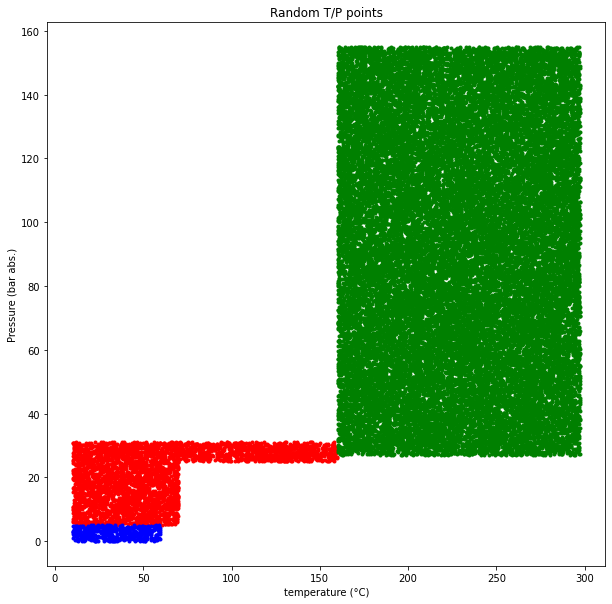

In [93]:
def angv_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] <= 297.2) & (array[:, 1] <= 155)
    
    return array[index]


#Performance indicator - remove if not needed - run the function 7000 times.
print('Boolean index AN/gv:\t', end='')
%timeit angv_index(quadrant[1]) # Quadrant II

angv_data = angv_index(quadrant[1])
print('Point in AN/GV quadrant:\t', len(angv_data))

plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
# plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
plt.plot(angv_data[:, 0], angv_data[:, 1], 'g.')
plt.show()